## Loading Data

In [37]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import mne

# Get the current file path
current_file_path = Path(os.path.abspath(""))

# Get the root path of the project
root_path = current_file_path.parents[0]

eeg_recordings_path = root_path / "eeg_recordings"
print(eeg_recordings_path)

/Users/anthonyricher/apps/neuro-clash/neuro_ai/eeg_recordings


In [38]:
# Load the csv data
# df = pd.read_csv(eeg_recordings_path / "EEG_recording_test_raw.csv")
df = pd.read_csv(eeg_recordings_path / "EEG_recording_antho_concentration_60.csv")
df.info()

# Assuming the EEG data is in columns named 'TP9', 'AF7', 'AF8', 'TP10', 'Right AUX'
# Adjust these according to your CSV file's structure
ch_names = ["TP9", "AF7", "AF8", "TP10"]
# Define channel types - assuming all channels are EEG
ch_types = ["eeg"] * len(ch_names)

# The first column is timestamps, which we don't need for the RawArray
eeg_data = df.iloc[:, 1:-1].T.values

# Create an MNE Info object (replace 256 with the actual sampling frequency)
info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)

# Create mne RawArray
raw = mne.io.RawArray(eeg_data, info)

# Add a montage (only necessary for plotting)
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

# Save as FIF format
raw.save(eeg_recordings_path / "EEG_recording_test_raw.fif", overwrite=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85032 entries, 0 to 85031
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamps  85032 non-null  float64
 1   Unnamed: 1  85032 non-null  float64
 2   Unnamed: 2  85032 non-null  float64
 3   Unnamed: 3  85032 non-null  float64
 4   Unnamed: 4  85032 non-null  float64
 5   Unnamed: 5  85032 non-null  float64
dtypes: float64(6)
memory usage: 3.9 MB
Creating RawArray with float64 data, n_channels=4, n_times=85032
    Range : 0 ... 85031 =      0.000 ...   332.152 secs
Ready.
Overwriting existing file.
Writing /Users/anthonyricher/apps/neuro-clash/neuro_ai/eeg_recordings/EEG_recording_test_raw.fif


Closing /Users/anthonyricher/apps/neuro-clash/neuro_ai/eeg_recordings/EEG_recording_test_raw.fif
[done]


## Filtering

In [39]:
# raw = mne.io.read_raw_fif(
#     eeg_recordings_path / "EEG_recording_test_raw.fif", preload=True
# )

# Apply band-pass filter
raw.filter(4, 40, method="iir")
# Filter for all bands
# raw.filter(1, 100, method="iir")

# Remove frequency above 40 Hz
# raw.plot(block=True, scalings="auto", lowpass=40, title="EEG recording")

# Optionally, apply a notch filter to remove power line noise at 50 Hz or 60 Hz
# raw.notch_filter(np.arange(50, 251, 50), filter_length="auto", phase="zero")

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,7 points
Good channels,4 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,4.00 Hz
Lowpass,40.00 Hz


## ICA for detecting Artifacts

In [40]:
# Apply ICA for artifact removal
ica = mne.preprocessing.ICA(n_components=4, random_state=0)
ica.fit(raw)
raw = ica.apply(raw)
ica.plot_components()

## Epochs
Segmenting data by Epochs can be used to do analysis on different patterns associated with certain activities or response

In [41]:
sfreq = raw.info["sfreq"]  # Sampling frequency
epoch_duration = 1  # Duration of each epoch in seconds
epoch_interval = 1  # Interval between epochs in seconds

# Calculate the number of samples per epoch
samples_per_epoch = int(epoch_duration * sfreq)

# Calculate total number of epochs
total_samples = len(raw.times)
print(raw.times)
total_epochs = int(total_samples / samples_per_epoch)

# Create the events array
events = np.zeros((total_epochs, 3), int)
for i in range(total_epochs):
    start_sample = i * int(epoch_interval * sfreq)
    events[i] = [start_sample, 0, 1]

# Create epochs
epochs = mne.Epochs(
    raw,
    events=events,
    event_id=1,
    tmin=0,
    tmax=epoch_duration,
    baseline=None,
    preload=True,
)

[0.00000000e+00 3.90625000e-03 7.81250000e-03 ... 3.32144531e+02
 3.32148438e+02 3.32152344e+02]
Not setting metadata
332 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 332 events and 257 original time points ...
0 bad epochs dropped


## PSD (power spectral density) to get Alpha and Beta power

In [42]:
# Normalize the data
epochs_data = epochs.get_data()
epochs_data_normalized = (epochs_data - np.mean(epochs_data)) / np.std(epochs_data)


# Calculate PSD with the full frequency range
psd, freqs = mne.time_frequency.psd_array_welch(
    epochs_data_normalized, sfreq, fmin=4, fmax=30, n_per_seg=256
)

# Find indices for alpha and beta bands
alpha_indices = np.where((freqs >= 8) & (freqs <= 12))[0]
beta_indices = np.where((freqs >= 13) & (freqs <= 30))[0]
# Find indices for other bands
# delta_indices = np.where((freqs >= 1) & (freqs <= 3))[0]
# theta_indices = np.where((freqs >= 4) & (freqs <= 7))[0]
# gamma_indices = np.where((freqs >= 31) & (freqs <= 100))[0]


# Extract and average the power for alpha and beta bands
alpha_power = psd[:, :, alpha_indices].mean(axis=2)
beta_power = psd[:, :, beta_indices].mean(axis=2)
# Extract other bands
# delta_power = psd[:, :, delta_indices].mean(axis=2)
# theta_power = psd[:, :, theta_indices].mean(axis=2)
# gamma_power = psd[:, :, gamma_indices].mean(axis=2)

Effective window size : 1.000 (s)


/var/folders/7c/6szjp3ds5752m6v6phw66phc0000gn/T/ipykernel_60416/2643786654.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()


## Data Visualization
Visualize the average power of the alpha and beta bands over time.

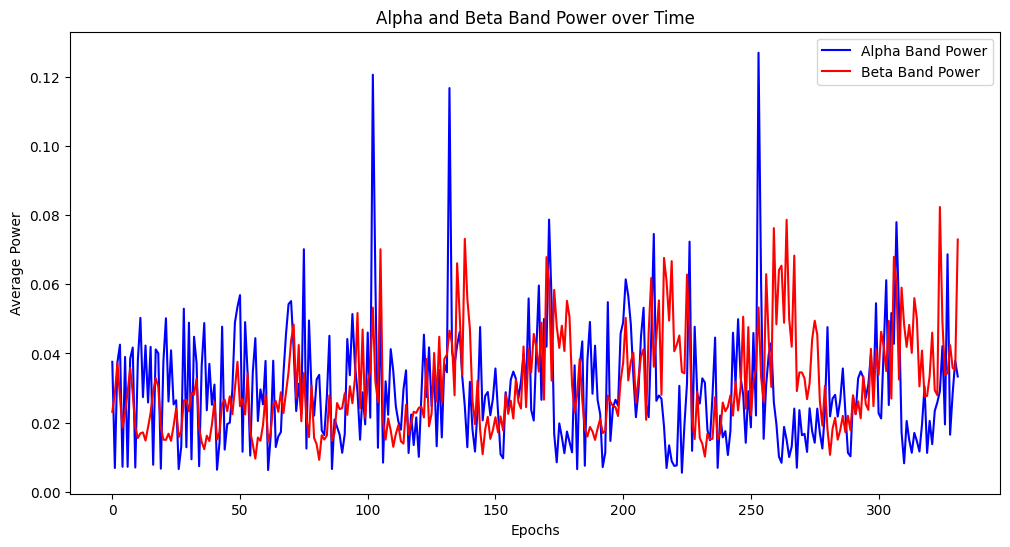

In [43]:
import matplotlib.pyplot as plt

# Calculate the average power across all channels for each epoch
mean_alpha_power = alpha_power.mean(axis=1)
mean_beta_power = beta_power.mean(axis=1)

# mean_delta_power = delta_power.mean(axis=1)
# mean_theta_power = theta_power.mean(axis=1)
# mean_gamma_power = gamma_power.mean(axis=1)

# Generate the epochs array (assuming you have the same number of epochs for both alpha and beta)
epochs_array = np.arange(len(mean_alpha_power))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(epochs_array, mean_alpha_power, label="Alpha Band Power", color="blue")
plt.plot(epochs_array, mean_beta_power, label="Beta Band Power", color="red")

# plt.plot(epochs_array, mean_delta_power, label="Delta Band Power", color="orange")
# plt.plot(epochs_array, mean_theta_power, label="Theta Band Power", color="yellow")
# plt.plot(epochs_array, mean_gamma_power, label="Gamma Band Power", color="green")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Average Power")
plt.title("Alpha and Beta Band Power over Time")
plt.legend()

# Show the plot
plt.show()

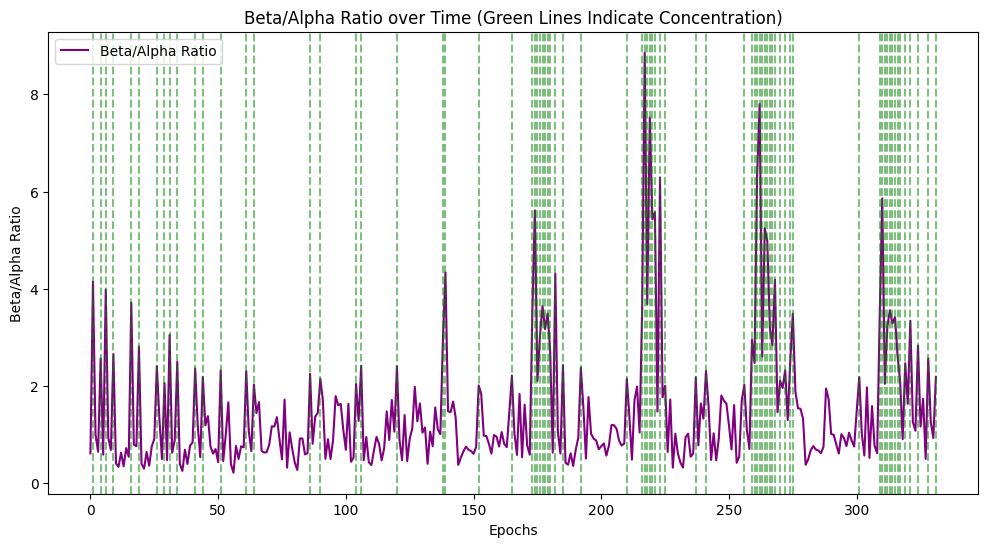

In [44]:
beta_alpha_ratio = mean_beta_power / mean_alpha_power

# Set a threshold for concentration
# This value is arbitrary and should be adjusted based on your data
concentration_threshold = 2

# Identify concentrated epochs
concentrated_epochs = beta_alpha_ratio > concentration_threshold

# Create the plot
plt.figure(figsize=(12, 6))

# Plotting Beta/Alpha Ratio
plt.plot(epochs_array, beta_alpha_ratio, label="Beta/Alpha Ratio", color="purple")

# Highlight concentrated epochs
for epoch, is_concentrated in enumerate(concentrated_epochs):
    if is_concentrated:
        plt.axvline(x=epoch, color="green", linestyle="--", alpha=0.5)

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Beta/Alpha Ratio")
plt.title("Beta/Alpha Ratio over Time (Green Lines Indicate Concentration)")
plt.legend()
plt.show()

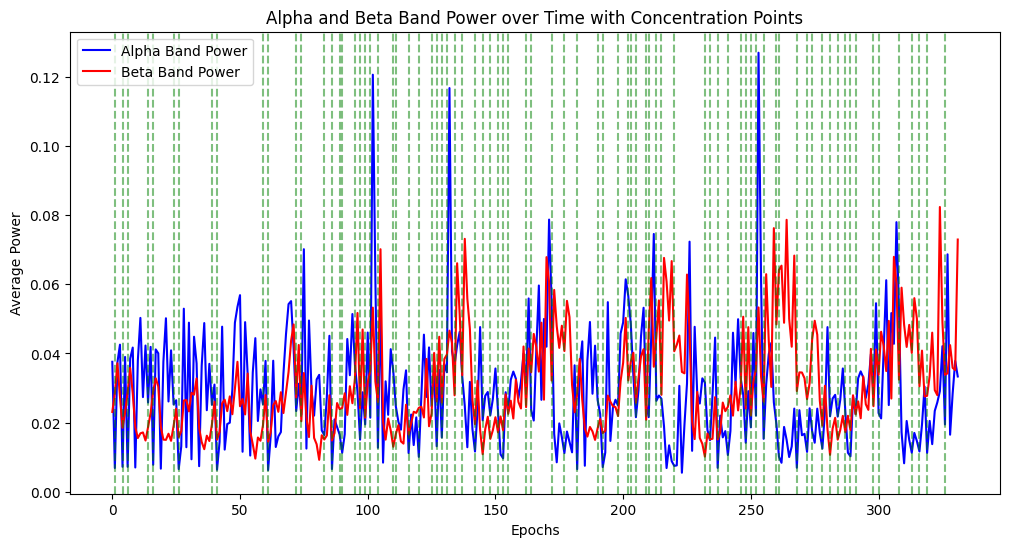

In [45]:
delta_alpha_power = np.diff(mean_alpha_power)
delta_beta_power = np.diff(mean_beta_power)

# Identify potential concentration points
concentration_points = []
for i in range(1, len(delta_alpha_power)):
    if delta_alpha_power[i - 1] < 0 and delta_beta_power[i] > 0:
        concentration_points.append(i)

# Create the plot
plt.figure(figsize=(12, 6))

# Plotting Alpha and Beta Power
plt.plot(epochs_array, mean_alpha_power, label="Alpha Band Power", color="blue")
plt.plot(epochs_array, mean_beta_power, label="Beta Band Power", color="red")

# Highlight concentration points
for point in concentration_points:
    plt.axvline(x=point, color="green", linestyle="--", alpha=0.5)

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Average Power")
plt.title("Alpha and Beta Band Power over Time with Concentration Points")
plt.legend()

# Show the plot
plt.show()